# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.701713,False,1.869219
1,0.132643,False,0.667514
2,-0.409500,False,-0.703595
3,-0.271013,True,4.240761
4,0.460016,True,6.246702
...,...,...,...
995,1.465487,True,9.836021
996,-0.019249,True,4.909124
997,0.344793,True,6.283251
998,0.558740,False,2.853064


<AxesSubplot: xlabel='v0'>

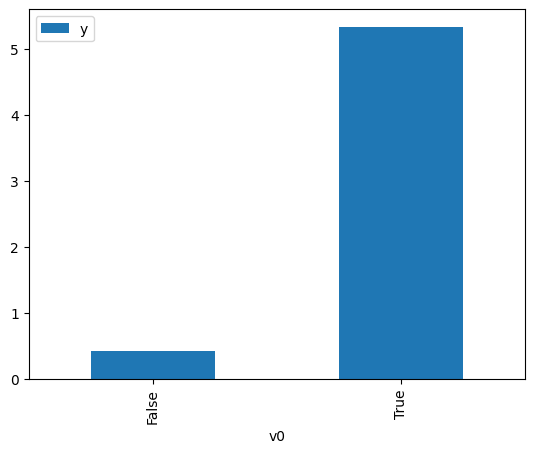

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

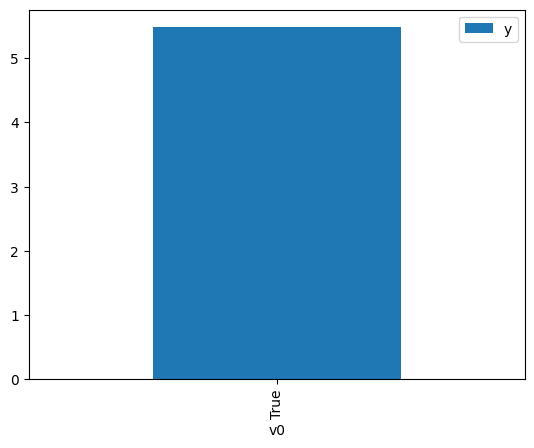

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.467248,False,-1.627827,0.572115,1.747899
1,0.716275,False,1.581694,0.324266,3.083892
2,1.574159,False,4.050267,0.185879,5.379855
3,0.407953,False,2.078734,0.385259,2.595655
4,0.953777,False,2.460929,0.280926,3.559656
...,...,...,...,...,...
995,-0.756579,False,-1.987343,0.632045,1.582167
996,0.996093,False,2.157881,0.273585,3.655177
997,1.088125,False,0.642409,0.258037,3.875410
998,1.549300,False,6.063918,0.189158,5.286591


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-2.678420,True,-0.640576,0.099304,10.070054
1,-1.467888,True,1.499838,0.239237,4.179957
2,-2.678420,True,-0.640576,0.099304,10.070054
3,0.282921,True,5.216686,0.588805,1.698354
4,0.919110,True,7.644282,0.712971,1.402582
...,...,...,...,...,...
995,0.641142,True,6.646965,0.661321,1.512125
996,0.321098,True,6.767981,0.596784,1.675648
997,0.864776,True,9.089998,0.703248,1.421973
998,-0.534850,True,2.238884,0.413620,2.417676


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.965
Model:                            OLS   Adj. R-squared (uncentered):              0.965
Method:                 Least Squares   F-statistic:                          1.363e+04
Date:                Wed, 19 Oct 2022   Prob (F-statistic):                        0.00
Time:                        15:56:08   Log-Likelihood:                         -1437.9
No. Observations:                1000   AIC:                                      2880.
Df Residuals:                     998   BIC:                                      2890.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.6607      0.034     77.427      0.000       2.593       2.728
x2             5.0065      0.046    107.695      0.000       4.915       5.098
==============================================================================
Omnibus:                        0.180   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.914   Jarque-Bera (JB):                0.251
Skew:                          -0.021   Prob(JB):                        0.882
Kurtosis:                       2.934   Cond. No.                         1.63
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""